# Ensembled Temperature Predictor

In [1]:
import gc
from typing import Iterable

import gsod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

gsod.enable_svg_graphing()
gsod.suppress_tf_log()

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
STATION = "722860"
ds = gsod.GsodDataset("runtime/GSOD")
interpolated = ds.read_continuous(stn=STATION, year="????", interpolate=True)
interpolated.describe().T

imfs_array = np.load("runtime/imfs.npy")
imfs = pd.DataFrame(imfs_array.T,
                    columns=[f"IMF_{n+1}" for n in range(len(imfs_array))])
imfs.index = interpolated.index
imfs.describe().T

,count,mean,std,min,25%,50%,75%,max
IMF_1,32353.0,-0.009430,1.445604,-8.087523,-0.937529,-0.013539,0.892774,7.803147
IMF_2,32353.0,-0.000710,0.226400,-1.986657,-0.147704,-0.002119,0.144548,2.557312
IMF_3,32353.0,-0.002454,1.171615,-6.026996,-0.733010,-0.013655,0.721976,5.444142
IMF_4,32353.0,-0.007266,1.717885,-9.450906,-1.154699,-0.017321,1.131476,9.775368
IMF_5,32353.0,-0.007274,1.716266,-7.401238,-1.194221,-0.019496,1.175146,6.731860
IMF_6,32353.0,-0.005901,1.587129,-5.786507,-1.135891,0.000732,1.119851,5.955110
IMF_7,32353.0,-0.003076,1.449131,-4.943888,-1.025639,-0.001348,1.046936,5.523331
IMF_8,32353.0,0.002960,1.185140,-4.647451,-0.801599,-0.004280,0.826147,4.903218
IMF_9,32353.0,-0.618600,6.772349,-13.748307,-6.355380,-1.847897,5.554219,14.069952
IMF_10,32353.0,-0.030497,2.982550,-7.628524,-2.406159,-0.043325,2.330340,6.980427


Load pre-trained models from disk.

In [3]:
def get_models():
    # Skip the last IMF (the trend term)
    return (tf.keras.models.load_model(f"runtime/IMF_{i + 1}.h5") for i in range(len(imfs.T) - 1))

Prediction helper for the LSTM model.

In [4]:
def predict_temperature(prev_imfs, models: Iterable[tf.keras.Model]) -> float:
    """Predict a single temperature from a window.
    
    Parameters
    ----------
        prev_imfs: (n_imfs, window_width) IMFs.
        models: List of models for each imf.
        
    Returns
    -------
    float
        Prediction.
    """
    result = 0.0
    for imf, model in zip(prev_imfs, models):
        model_input = imf.reshape(1, -1, 1)
        result += model(model_input)[0, -1, 0]
    return result

def batch_predict_temperature(
    imfs,
    models: Iterable[tf.keras.Model],
    *,
    window_width: int = 7,
    n_predictions: int = -1
):
    """Predict a single temperature from a window.
    
    Parameters
    ----------
        imfs: (n_imfs, n_predictions + window_width - 1) IMFs for predictions.
              If the length of the second dimension is larger, the extra ones
              at the front will be ignored.
        models: List of models for each imf.
        window_width: width of the window.
        n_predictions: number of predictions to make. Default of -1 for all.
        
    Returns
    -------
    NDArray[float]
        Predictions.
    """
    # Reset n_predictions for all
    if n_predictions < 0:
        n_predictions = imfs.shape[1] + 1 - window_width
    # Pre-allocate array
    result = np.zeros(n_predictions)
    for imf, model in zip(imfs, models):
        imf_to_use = imf[-(n_predictions + window_width - 1):]
        window = gsod.sliding_window(imf_to_use, window_width)
        # Add each IMF's result to the prediction
        result += model.predict(
            window.reshape(-1, window_width, 1)
        # window_width - shift
        )[:, window_width - 1, 0]
        tf.keras.backend.clear_session()
        gc.collect()
    return result

In [5]:
with tf.device("/cpu:0"):
    result = batch_predict_temperature(np.asarray(imfs.T)[:-1], get_models())

Metal device set to: Apple M1


In [6]:
# The last temperature is the future, so skip its calculation
prediction = result[:-1] + imfs[imfs.columns[-1]][7:]
actual = np.asarray(interpolated["TEMP"])[7:]
indices = interpolated.index[7:]

Text(0, -50, 'MAE: 0.7414${}^\\circ$F\nRMSE: 0.9718${}^\\circ$F')

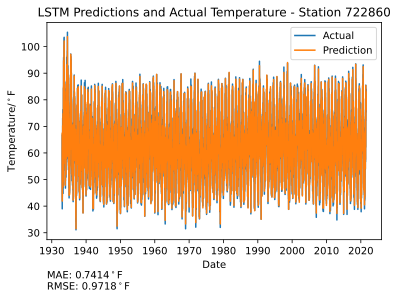

In [7]:
plt.plot(indices, actual, label="Actual")
plt.plot(indices, prediction, label="Prediction")
plt.legend()
plt.title(f"LSTM Predictions and Actual Temperature - Station {STATION}")
plt.xlabel("Date")
plt.ylabel("Temperature/${}^\circ$F")
plt.annotate(
    f"MAE: {np.average(np.abs(prediction - actual)):0.4}${{}}^\circ$F\n"
    + f"RMSE: {np.average((prediction - actual)**2)**0.5:0.4}${{}}^\circ$F",
    (0, -50),
    xycoords="axes points"
)

Text(0, -50, 'MAE: 0.7027${}^\\circ$F\nRMSE: 0.8897${}^\\circ$F')

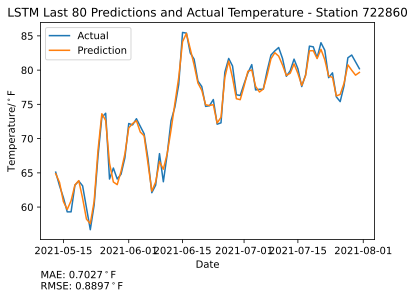

In [8]:
plt.plot(indices[-80:], actual[-80:], label="Actual")
plt.plot(indices[-80:], prediction[-80:], label="Prediction")
plt.legend()
plt.title(f"LSTM Last 80 Predictions and Actual Temperature - Station {STATION}")
plt.xlabel("Date")
plt.ylabel("Temperature/${}^\circ$F")
plt.annotate(
    f"MAE: {np.average(np.abs(prediction[-80:] - actual[-80:])):0.4}${{}}^\circ$F\n"
    + f"RMSE: {np.average((prediction[-80:] - actual[-80:])**2)**0.5:0.4}${{}}^\circ$F",
    (0, -50),
    xycoords="axes points"
)